# Second model: feature extraction

This notebook describes how to create a CNN for classifying dogs and cats using feature extraction. Feature extraction involves using a pretrained CNN (like VGG16) for feature extraction. Then, we train a neural network using the resulting features.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint

In [3]:
def load_rcparams(figsize=None):
    """
    Load a custom rcParams dictionary
    """
    
    rcParams['axes.titlesize']  = 14            # title
    rcParams['axes.labelsize']  = 10            # $f_i$ labels
    rcParams['xtick.color']     = "#474747"     # ticks gray color
    rcParams['ytick.color']     = "#474747"     # ticks gray color
    rcParams['xtick.labelsize'] = 10            # ticks size
    rcParams['ytick.labelsize'] = 10            # ticks size
    rcParams['legend.fontsize'] = 12            # legend
    rcParams['legend.fontsize'] = 12            # legend

    if isinstance(figsize, tuple):
        rcParams['figure.figsize'] = figsize    

def extract_features(conv_base, directory, sample_count):
    """
    Return feature vectors from images
    
        features = conv_base.predict(inputs_batch)
    """
    
    datagen = ImageDataGenerator(rescale=1./255)
    batch_size = 20
    
    features = np.zeros((sample_count, 4, 4, 512))      # this is the shape of the last feature map of vgg16 (using include_top=False)
    labels = np.zeros((sample_count, ))
    
    generator = datagen.flow_from_directory(
                        directory,
                        target_size=(150, 150),
                        batch_size=batch_size,
                        class_mode="binary")
                        
    i = 0
    for inputs_batch, labels_batch in generator:        # que forma tiene cada batch
                                                        # inputs_batchs is a numpy array of PIL->numpy matrices?
                                                        # labels_batchs is a numpy array with the real labels of the input images?
        # compute feature vectors
        features_batch = conv_base.predict(inputs_batch)
        
        # debug
        print("features_batch shape", features_batch.shape)
        
        # save feature vectors
        a = i * batch_size
        b = (i+1) * batch_size
        features[a:b] = features_batch.copy()
        labels[a:b] = labels_batch.copy()
        
        i+=1
        
        if i * batch_size >= sample_count:
            # stop feature extraction after loading the max amount of images (sample_count)
            # otherwise, some images (ie, feature vectors) will be duplicated
            break
            
    return features, labels

In [4]:
base_dir = "/media/data/dogs_vs_cats_small"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")


# use this flag to enable feature extraction
# this step is perfomed only once
extract_features_flag = False

**Feature extraction** consists of using the representations learned by a previous network to extract interesting features for new samples. These features are then run through a new classifier, which is trained from scratch.

Convents comprises two parts:

- Convolutional base: a series of convolution and pooling layers. 
- Classifier: densely-connected layers.

Feature extraction consists of taking the convolutional base of a previously trained network, running new data through it, and training a new classifier on top of the output.

![](feature_extraction.bmp)


By doing this, we take advantage of the representations learned by a previously trained network. These representations (learned by the convolutional base) are likely to be more generic and therefore more reusable. On the other hand, the representations learned by the classifier will be specific to the set of classes on which the model is trained.

In this notebook, we will use the representations learned by VGG16 [[paper: Very Deep Convolutional Networks for Large-Scale Image Recognition]](https://arxiv.org/abs/1409.1556)



![](vgg16.png)


[source](https://neurohive.io/en/popular-networks/vgg16/)

In [6]:
# Listing 5.16
# Instantiate the VGG16 model
conv_base = VGG16(
            weights="imagenet",
            include_top=False,          # include or not the densely connected classifier on top of the network
            input_shape=(150, 150, 3)   # shape of the image tensors that you will feed to the network
                )

if extract_features_flag:

    # Listing 5.17
    # Extracting features using the pretrained convolutional base

    # extract features
    train_features, train_labels = extract_features(conv_base, train_dir, 2000)
    validation_features, validation_labels = extract_features(conv_base, validation_dir, 1000)
    test_features, test_labels = extract_features(conv_base, test_dir, 1000)

    # reshape features
    train_features = np.reshape(train_features, (2000, 4*4*512))
    validation_features = np.reshape(validation_features, (1000, 4*4*512))
    test_features = np.reshape(test_features, (1000, 4*4*512))

    # save features
    np.savetxt(os.path.join(base_dir, "train_features.txt"), train_features)
    np.savetxt(os.path.join(base_dir, "validation_features.txt"), validation_features)
    np.savetxt(os.path.join(base_dir, "test_features.txt"), test_features)

    # save labels
    np.savetxt(os.path.join(base_dir, "train_labels.txt"), train_labels)
    np.savetxt(os.path.join(base_dir, "validation_labels.txt"), validation_labels)
    np.savetxt(os.path.join(base_dir, "test_labels.txt"), test_labels)    

Now, let's check the model:

In [7]:
# check the model
conv_base.summary()
print("This is the number of trainable weights of the conv base:", len(conv_base.trainable_weights))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

From the previous block, notice that the shape of the last feature map is `(4, 4, 512)`. We will use this feature map to train our neural network.

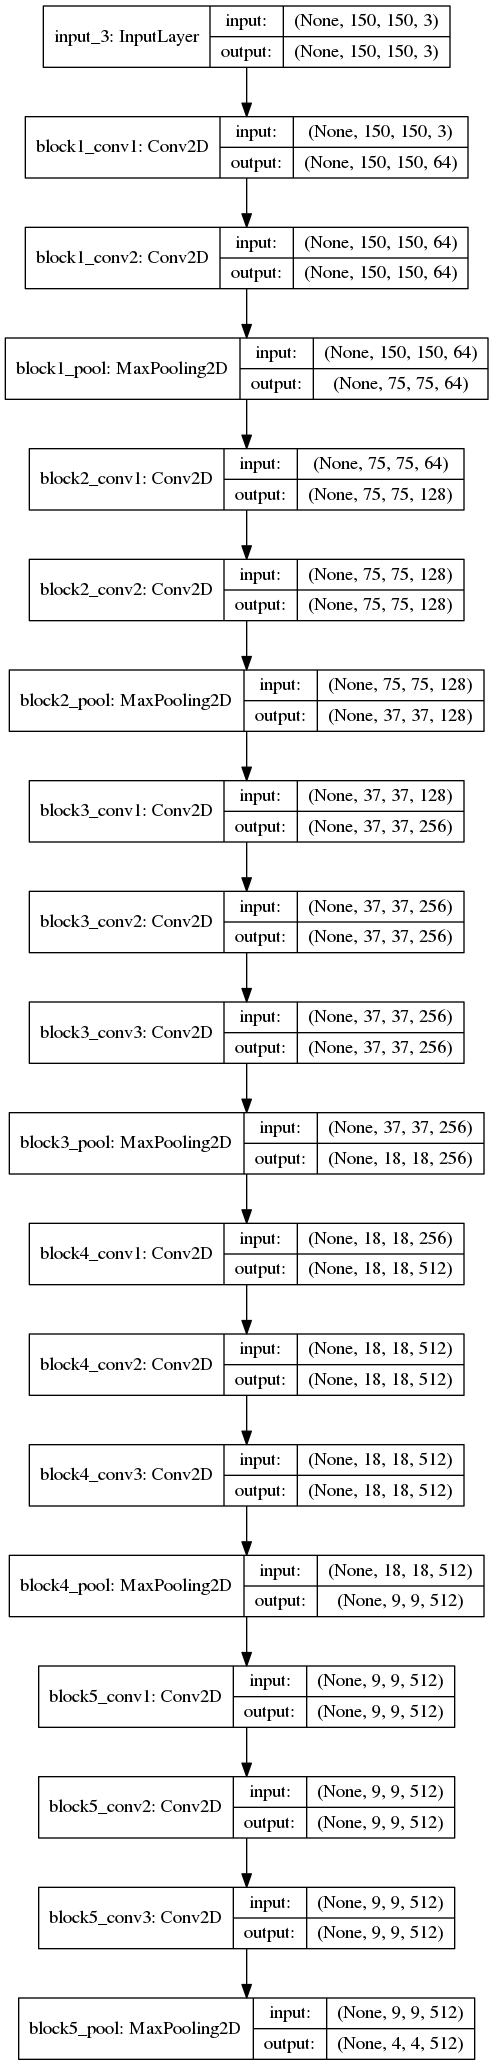

In [12]:
from keras.utils import plot_model
plot_model(conv_base, show_shapes=True)

In [8]:
# debug: use this line to show the shape of the features 
train_features, train_labels = extract_features(conv_base, train_dir, 40)   

Found 2000 images belonging to 2 classes.
features_batch shape (20, 4, 4, 512)
features_batch shape (20, 4, 4, 512)


 Also, notice that the shape of `features_batch` is `(20, 4, 4, 512)`, that is, `(batch_size, 4, 4, 512)` or `(batch_size, 8192)` after flatting all the features:

```
features_batch shape (20, 4, 4, 512)
```

The resulting features are stored in `/media/data/dogs_vs_cats_small`:

```
(dev) auraham@rocket:/media/data/dogs_vs_cats_small$ ls
test               train               validation
test_features.txt  train_features.txt  validation_features.txt
test_labels.txt    train_labels.txt    validation_labels.txt
```

Remember, these features are extracted using VGG16, meaning that they are potentially good descriptors for our tasks, i.e., classification of dogs and cats.

These files are relatively large, so it will take a few seconds to load them into memory:

```
(dev) auraham@rocket:/media/data/dogs_vs_cats_small$ ls -lh
total 782M
drwxrwxr-x 4 auraham auraham 4.0K oct  2 06:08 test
-rw-rw-r-- 1 auraham auraham 196M ene  7 22:19 test_features.txt
-rw-rw-r-- 1 auraham auraham  25K ene  7 23:01 test_labels.txt
drwxrwxr-x 4 auraham auraham 4.0K oct  2 06:08 train
-rw-rw-r-- 1 auraham auraham 391M ene  7 22:19 train_features.txt
-rw-rw-r-- 1 auraham auraham  49K ene  7 23:01 train_labels.txt
drwxrwxr-x 4 auraham auraham 4.0K oct  2 06:08 validation
-rw-rw-r-- 1 auraham auraham 196M ene  7 22:19 validation_features.txt
-rw-rw-r-- 1 auraham auraham  25K ene  7 23:01 validation_labels.txt
```

Below, we will load the features (**it will take a lot of memory**). Then, we will train a small neural network using these features. Finally, we will evaluate the performance of the network.

In [6]:
# this will take a few seconds (requires a lot of memory, about 3.5 Gb)
print("loading features...")

# load features from file
train_features = np.genfromtxt(os.path.join(base_dir, "train_features.txt"))
train_labels = np.genfromtxt(os.path.join(base_dir, "train_labels.txt"))

validation_features = np.genfromtxt(os.path.join(base_dir, "validation_features.txt"))
validation_labels = np.genfromtxt(os.path.join(base_dir, "validation_labels.txt"))

test_features = np.genfromtxt(os.path.join(base_dir, "test_features.txt"))
test_labels = np.genfromtxt(os.path.join(base_dir, "test_labels.txt"))

print("OK")

loading features...
OK


In [10]:
print("train features:", train_features.shape)
print("train labels:  ", train_labels.shape)

train features: (2000, 8192)
train labels:   (2000,)


**This will take a lot of time** Now, let's train the model.

In [7]:
# Listing 5.18
# Defining and training the densely connected classifier
model = models.Sequential()
model.add(layers.Dense(256, activation="relu", input_dim=4*4*512))      # alternatively, you can use input_shape=(4*4*512,)
model.add(layers.Dropout(0.5))                                          # p 110, removing a few neurons would reduce overfitting
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
            optimizer=optimizers.RMSprop(lr=2e-5),
            loss="binary_crossentropy",
            metrics=["acc"]
            )

# add a callback to save the model during training
callbacks = [
        ModelCheckpoint(
            filepath="dogs_vs_cats_v2_callback.h5",
            monitor="val_loss",                         # these two arguments mean you won't overwrite the
            save_best_only=True,                        # model file unless val_loss has improved, which allows
        )                                               # you to keep the best model seen during training
    ]

# each epoch takes 5s in my computer
# Epoch 30/30
# 2000/2000 [==============================] - 3s 2ms/step - loss: 0.0904 - acc: 0.9720 - val_loss: 0.2458 - val_acc: 0.9010
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks=callbacks
                    )

# save model
print("saving model...")
model.save("dogs_vs_cats_v2.h5")
print("OK")

W0307 16:45:15.382388 140095542540032 deprecation_wrapper.py:119] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0307 16:45:15.471186 140095542540032 deprecation_wrapper.py:119] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0307 16:45:15.486612 140095542540032 deprecation_wrapper.py:119] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0307 16:45:15.519375 140095542540032 deprecation_wrapper.py:119] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is depre

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6257 - acc: 0.6445 - val_loss: 0.4560 - val_acc: 0.8220
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4358 - acc: 0.8040 - val_loss: 0.3681 - val_acc: 0.8650
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3585 - acc: 0.8535 - val_loss: 0.3255 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3118 - acc: 0.8685 - val_loss: 0.2976 - val_acc: 0.8880
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2906 - acc: 0.8850 - val_loss: 0.2834 - val_acc: 0.8840
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2736 - acc: 0.8965 - val_loss: 0.2722 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2493 - acc: 0.9020 - val_loss: 0.2609 - val_acc: 0.9020
Epoch 8/30
200

Finally, we can evaluate the performance of the network:

['loss', 'acc']
1000/1000 [==============================] - 0s 180us/step
test acc: 0.8800
build_model_v2_feature_extraction.png


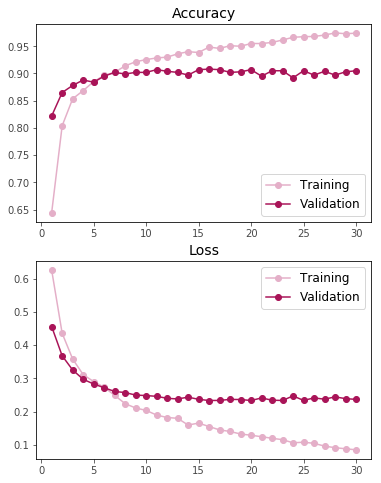

In [17]:
# use this command to show the metrics (required to know the output of model.evaluate)
print(model.metrics_names)

# evaluate model
test_loss, test_acc = model.evaluate(test_features, test_labels, batch_size=20)
print("test acc: %.4f" % test_acc)          # test acc: 0.8910

# Listing 5.19
# Plotting the results
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

load_rcparams((6, 8))

fig = plt.figure()
ax_acc = fig.add_subplot(211)
ax_loss = fig.add_subplot(212)

ax_acc.plot(epochs, acc, "o", color="#E4AFC8", ls="-", label="Training")
ax_acc.plot(epochs, val_acc, "o", color="#A91458", ls="-", label="Validation")
ax_acc.set_title("Accuracy")
ax_acc.legend()

ax_loss.plot(epochs, loss, "o", color="#E4AFC8", ls="-", label="Training")
ax_loss.plot(epochs, val_loss, "o", color="#A91458", ls="-", label="Validation")
ax_loss.set_title("Loss")
ax_loss.legend()

# save plot
output = "build_model_v2_feature_extraction.png"
fig.savefig(output, dpi=300)
print(output)

plt.show()

The accuracy of the final model is 88%. That is a huge improvement from our previous model (69%)